# Distributed Prioritised DQN Anakin Agent in `Jumanji` using `flashbax`
### [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/instadeepai/flashbax/blob/main/examples/anakin_prioritised_dqn_example.ipynb)

Adapted from [Gymnax Example](https://colab.research.google.com/github/RobertTLange/gymnax/blob/main/examples/01_anakin.ipynb) and DeepMind's [Example Colab](https://colab.research.google.com/drive/1974D-qP17fd5mLxy6QZv-ic4yxlPJp-G?usp=sharing#scrollTo=lhnJkrYLOvcs)

### Imports

In [ ]:
!git clone https://github.com/instadeepai/flashbax.git
!pip install ./flashbax[examples]

In [1]:
import flashbax as fbx

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import jax
from jax import lax
from jax import random
from jax import numpy as jnp
import jax.numpy as jnp
import haiku as hk
import optax
import rlax
import timeit
import distrax
import chex
from jumanji.wrappers import AutoResetWrapper
import jumanji

print("The following devices are available: ", jax.devices())

2023-09-26 15:54:10.016603: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1695743651.349688 1520857 pjrt_api.cc:98] GetPjrtApi was found for tpu at /home/e.toledo/miniconda3/envs/flashbax/lib/python3.10/site-packages/libtpu/libtpu.so
I0000 00:00:1695743651.349773 1520857 pjrt_api.cc:67] PJRT_Api is set for device type tpu
I0000 00:00:1695743651.349776 1520857 pjrt_api.cc:72] PJRT plugin for tpu has PJRT API version 0.30. The framework PJRT API version is 0.30.


The following devices are available:  [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


I0000 00:00:1695743654.396450 1520857 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


### Anakin DQN Distributed Agent Setup
The following is a DQN implementation in the Anakin framework.

In [3]:
@chex.dataclass(frozen=True)
class TimeStep:
    observation: chex.Array
    action: chex.Array
    discount: chex.Array
    reward: chex.Array


@chex.dataclass(frozen=True)
class Params:
    online: hk.Params
    target: hk.Params
    update_count: int


def get_network_fn(num_outputs: int):
    def network_fn(obs: chex.Array) -> chex.Array:
        """Outputs action logits."""
        network = hk.Sequential(
            [
            hk.Conv2D(32, kernel_shape=2, stride=1),
            jax.nn.relu,
            hk.Conv2D(32, kernel_shape=2, stride=1),
            jax.nn.relu,
            hk.Flatten(),
            hk.Linear(256),
            jax.nn.relu,
            hk.Linear(128),
            jax.nn.relu,
            hk.Linear(num_outputs),
            ]
        )
        return network(obs)

    return hk.without_apply_rng(hk.transform(network_fn))


def get_learner_fn(
    env,
    forward_pass,
    buffer_fn,
    opt_update,
    rollout_len,
    agent_discount,
    iterations,
    target_period,
    epsilon_schedule_fn,
    sgd_steps_per_rollout,
    importance_sampling_exponent,
):
    """Returns a learner function that can be used to update parameters."""

    def rollout(params_state, outer_rng, env_state, env_timestep):
        """Collects a trajectory from the environment."""
        def step_fn(env_data, rng):
            """Steps the environment and collects transition data."""
            (env_state, env_timestep, params_state) = env_data
            obs_tm1 = env_timestep.observation.grid  
            d_tm1 = env_timestep.discount  
            q_values_tm1 = forward_pass(params_state.online, jnp.expand_dims(obs_tm1, 0))  
            a_tm1_dist = distrax.EpsilonGreedy(preferences=q_values_tm1[0], epsilon=epsilon_schedule_fn(params_state.update_count))
            a_tm1 = a_tm1_dist.sample(seed=rng) 
            new_env_state, new_env_timestep = env.step(env_state, a_tm1)  #
            r_t = new_env_timestep.reward 
            return (
                new_env_state,
                new_env_timestep,
                params_state,
            ), TimeStep(  # return env state and transition data.
                observation=obs_tm1, action=a_tm1, discount=d_tm1, reward=r_t
            ) # We line up the observation with its discount, not the discount of the next observation as is usually seen.
              # This is so that we know in a transition that discount[1] is the discount of the next observation. 
              # e.g. indexing is v[t] = reward[t] + discount[t+1]*value[t+1]
              # Switching to Sutton and Barto's notation, we would have v[t] = reward[t+1] + discount[t+1]*value[t+1]
              # To do this, we would add r_tm1 = env_timestep.reward to the TimeStep dataclass, not the new_env_timestep.reward

        step_rngs = jax.random.split(outer_rng, rollout_len)
        (env_state, env_timestep, params_state), rollout = lax.scan(
            step_fn, (env_state, env_timestep, params_state), step_rngs
        )  # trajectory.

        return rollout, env_state, env_timestep

    def loss_fn(params, target_params, batch):
        """Computes the loss for a single batch."""
        # For ease of reading
        o_tm1 = batch.experience.first.observation
        a_tm1 = batch.experience.first.action.astype(jnp.int32)
        r_t = batch.experience.first.reward
        d_t = agent_discount * batch.experience.second.discount
        o_t = batch.experience.second.observation
        # Compute Q-values for current and next states.
        q_tm1 = forward_pass(params, o_tm1) 
        q_t = forward_pass(target_params, o_t)  
        q_t_select = forward_pass(params, o_t)
        # Compute the TD-error.
        td_error = jax.vmap(
            rlax.double_q_learning
        )(  # compute multi-step temporal diff error.
            q_tm1=q_tm1,  # predictions.
            a_tm1=a_tm1,  # actions.
            r_t=r_t,  # rewards.
            discount_t=d_t,  # discount.
            q_t_value=q_t,  # target values.
            q_t_selector=q_t_select,  # selector values.
        )

        batch_loss = rlax.l2_loss(td_error)  # compute L2 loss.

        # Get the importance weights.
        importance_weights = (1. / batch.priorities).astype(jnp.float32)
        importance_weights **= importance_sampling_exponent
        importance_weights /= jnp.max(importance_weights)

        # Reweight.
        loss = jnp.mean(importance_weights * batch_loss)
        new_priorities = jnp.abs(td_error) + 1e-7
        return loss, new_priorities

    def update_fn(
        params_state: Params, buffer_state, opt_state, rng, env_state, env_timestep
    ):
        """Updates the parameters of the agent."""
        rng, rollout_rng, update_rng = random.split(rng, 3)

        data_rollout, new_env_state, new_env_timestep = rollout(
            params_state, rollout_rng, env_state, env_timestep
        )  # collect trajectory from environment. This could be one step, or many steps.

        buffer_state = buffer_fn.add(buffer_state, data_rollout)  # store trajectory in buffer.
        
        def sgd_step(carry, rng):
            """Performs a single SGD step."""
            params_state, opt_state, buffer_state = carry
            
            batch = buffer_fn.sample(buffer_state, rng)  # sample batch from buffer.

            params, target_params = params_state.online, params_state.target
            grads, new_priorities = jax.grad(loss_fn, has_aux=True)(  # compute gradient on a single trajectory.
                params, target_params, batch
            )
            grads = lax.pmean(grads, axis_name="j")  # reduce mean across cores.
            grads = lax.pmean(grads, axis_name="i")  # reduce mean across batch.
            updates, new_opt_state = opt_update(grads, opt_state)  # transform grads.
            new_params = optax.apply_updates(params, updates)  # update parameters.
            target_params = optax.periodic_update(  # update target parameters.
                new_params, target_params, params_state.update_count + 1, target_period
            )
            new_params_state = Params(  # update parameters state.
                online=new_params,
                target=target_params,
                update_count=params_state.update_count + 1,
            )

            buffer_state = buffer_fn.set_priorities(buffer_state, batch.indices, new_priorities)  # update priorities.

            return (new_params_state, new_opt_state, buffer_state), None

        real_update_fn = lambda p_state, o_state, b_state, rng: jax.lax.scan(sgd_step, (p_state, o_state, b_state), jax.random.split(rng, sgd_steps_per_rollout))[0]
        fake_update_fn = lambda p_state, o_state, b_state, _: (p_state, o_state, b_state)

        new_params_state, new_opt_state, buffer_state = jax.lax.cond(  # conditional update.
            buffer_fn.can_sample(buffer_state),  # if buffer can sample.
            real_update_fn,  # perform update.
            fake_update_fn,  # else do nothing.
            params_state,
            opt_state,
            buffer_state,
            update_rng,
        )

        return (
            new_params_state,
            buffer_state,
            new_opt_state,
            rng,
            new_env_state,
            new_env_timestep,
        )

    def learner_fn(
        params_state: Params, buffer_state, opt_state, rngs, env_states, env_timesteps
    ):
        """Performs multiple SGD steps."""
        batched_update_fn = jax.vmap(
            update_fn, axis_name="j"
        )  # vectorize across batch.

        def iterate_fn(_, val):  # repeat many times to avoid going back to Python.
            params_state, buffer_state, opt_state, rngs, env_states, env_timesteps = val
            return batched_update_fn(
                params_state, buffer_state, opt_state, rngs, env_states, env_timesteps
            )

        return lax.fori_loop(
            0,
            iterations,
            iterate_fn,
            (params_state, buffer_state, opt_state, rngs, env_states, env_timesteps),
        )

    return learner_fn

### Create Experiment Fns

In [4]:

def set_up_experiment(
    env,
    batch_size,
    step_size,
    seed,
    buffer_size,
    epsilon_init,
    epsilon_final,
    epsilon_steps,
    priority_exponent,
):
    """Sets up the experiment."""
    cores_count = len(jax.devices())  # get available TPU cores.
    network = get_network_fn(env.action_spec.num_values)  # define network.
    optim = optax.adam(step_size)  # define optimiser.

    rng, rng_e, rng_p = random.split(random.PRNGKey(seed), num=3)  # prng keys.
    _, timestep = env.reset(rng_e)
    obs = timestep.observation.grid
    dummy_obs = jnp.expand_dims(obs, 0)  # dummy for net init.
    params = network.init(rng_p, dummy_obs)  # initialise params.
    opt_state = optim.init(params)  # initialise optimiser stats.
    buffer_fn = fbx.make_prioritised_flat_buffer(
        max_length=buffer_size,
        min_length=batch_size,
        sample_batch_size=batch_size,
        add_sequences=True,
        add_batch_size=None,
        priority_exponent=priority_exponent,
    )
    buffer_state = buffer_fn.init(
        TimeStep(
            observation=obs,
            action=jnp.zeros((), dtype=jnp.int32),
            reward=jnp.zeros(()),
            discount=jnp.zeros(()),
        )
    )  # initialise buffer state.
    epsilon_schedule_fn = optax.linear_schedule(
        epsilon_init, epsilon_final, epsilon_steps
    )  # define epsilon schedule.
    return (
        cores_count,
        network,
        optim,
        params,
        opt_state,
        buffer_fn,
        buffer_state,
        rng,
        epsilon_schedule_fn,
    )


def get_rng_keys(cores_count, num_envs, rng):
    """Returns a batch of random number generator keys."""
    rng, *step_rngs = jax.random.split(rng, cores_count * num_envs + 1)
    reshape = lambda x: x.reshape((cores_count, num_envs) + x.shape[1:])
    step_rngs = reshape(jnp.stack(step_rngs))  # add dimension to pmap over.
    return rng, step_rngs


def broadcast_to_device_shape(
    cores_count, num_envs, params, opt_state, buffer_state, rng
):
    """Broadcasts parameters to device shape."""
    broadcast = lambda x: jnp.broadcast_to(x, (cores_count, num_envs) + x.shape)
    params = jax.tree.map(broadcast, params)  # broadcast to cores and batch.
    opt_state = jax.tree.map(broadcast, opt_state)  # broadcast to cores and batch
    buffer_state = jax.tree.map(broadcast, buffer_state)  # broadcast to cores and batch
    params_state = Params(
        online=params,
        target=params,
        update_count=jnp.zeros(shape=(cores_count, num_envs)),
    )
    rng, step_rngs = get_rng_keys(cores_count, num_envs, rng)
    return params_state, opt_state, buffer_state, step_rngs, rng

### Create Environment

In [5]:
# We separate the environment into a training and evaluation environment. Training resets the environment automatically, while evaluation does not.
env = jumanji.make("Snake-v1", num_rows=6, num_cols=6)
training_env = AutoResetWrapper(env)

### Set up Parameters

In [6]:
# Number of Training-Evaluation iterations
TRAINING_EVAL_ITERS = 10

# Training parameters
BATCH_SIZE = 32
LEARNING_RATE = 5e-4
SEED = 42
NUM_ENVS = 8
BUFFER_SIZE = 10_000
ROLLOUT_LEN = 512
SGD_STEPS_PER_ROLLOUT = 64
TRAINING_ITERS = 20
TARGET_PERIOD = 10
AGENT_DISCOUNT = 0.99
EPSILON_INIT = 1.0
EPSILON_FINAL = 0.1
EPSILON_STEPS = 10_000
PRIORTIY_EXPONENT = 0.6
IMPORTANCE_SAMPLING_EXPONENT = 0.6

# Evaluation parameters
NUM_EVAL_EPISODES = 50

### Set Up Eval Fns

In [7]:
(
    cores_count,
    network,
    optim,
    params,
    opt_state,
    buffer_fn,
    buffer_state,
    rng,
    epsilon_schedule_fn,
) = set_up_experiment(
    env=training_env,
    batch_size=BATCH_SIZE,
    step_size=LEARNING_RATE,
    seed=SEED,
    buffer_size=BUFFER_SIZE,
    epsilon_steps=EPSILON_STEPS,
    epsilon_init=EPSILON_INIT,
    epsilon_final=EPSILON_FINAL,
    priority_exponent=PRIORTIY_EXPONENT,
)

@jax.jit
def eval_one_episode(params, rng):
    """Evaluates one episode."""
    state, timestep = env.reset(rng)
    
    def step(val):
        params, state, timestep, tot_r, rng, done = val
        rng, key_step = jax.random.split(rng)
        obs = timestep.observation.grid
        q_values = network.apply(params, obs[jnp.newaxis,])
        a_t = jnp.argmax(q_values, axis=-1)[0]
        state, timestep = env.step(state, a_t)
        tot_r += timestep.reward
        return (params, state, timestep, tot_r, rng, timestep.last())
       
    params, state, timestep, tot_r, rng, done = jax.lax.while_loop(lambda val : val[5] == False, step, (params, state, timestep, 0, rng, False))

    return params, tot_r

@jax.jit
def eval(params, rng):
    """Evaluates multiple episodes."""
    rngs = random.split(rng, NUM_EVAL_EPISODES)
    params = jax.tree.map(lambda x: x[0][0], params)
    _, tot_r = jax.lax.scan(eval_one_episode, params, rngs)
    return tot_r.mean()

/home/e.toledo/flashbax/flashbax/buffers/trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 10000`.This allows one to control exactly how many transitions are stored in the buffer.Note that this overrides the `max_length_time_axis` argument.
  warnings.warn(


## Perform Training

In [8]:
rng, *env_rngs = jax.random.split(rng, cores_count * NUM_ENVS + 1)
env_states, env_timesteps = jax.vmap(env.reset)(jnp.stack(env_rngs))  # init envs.
reshape = lambda x: x.reshape((cores_count, NUM_ENVS) + x.shape[1:])
env_states = jax.tree.map(reshape, env_states)  # add dimension to pmap over.
env_timesteps = jax.tree.map(reshape, env_timesteps)  # add dimension to pmap over.
params_state, opt_state, buffer_state, step_rngs, rng = broadcast_to_device_shape(
    cores_count, NUM_ENVS, params, opt_state, buffer_state, rng
)

learn = get_learner_fn(
    env=training_env,
    forward_pass=network.apply,
    buffer_fn=buffer_fn,
    opt_update=optim.update,
    rollout_len=ROLLOUT_LEN,
    agent_discount=AGENT_DISCOUNT,
    iterations=TRAINING_ITERS,
    target_period=TARGET_PERIOD,
    epsilon_schedule_fn=epsilon_schedule_fn,
    sgd_steps_per_rollout=SGD_STEPS_PER_ROLLOUT,
    importance_sampling_exponent=IMPORTANCE_SAMPLING_EXPONENT,
)
learn = jax.pmap(learn, axis_name="i")  # replicate over multiple cores.


avg_reward = []
total_time = 0
for training_eval_iters in range(TRAINING_EVAL_ITERS):
    # Train
    start = timeit.default_timer()
    params_state, buffer_state, opt_state, step_rngs, env_states, env_timesteps = learn(params_state, buffer_state, opt_state, step_rngs, env_states, env_timesteps)
    params_state = jax.tree.map(lambda x: x.block_until_ready(), params_state) # wait for params to be ready so time is accurate.
    total_time += timeit.default_timer() - start
    # Eval
    rng, eval_rng = jax.random.split(rng, num=2)
    tot_r = eval(params_state.online, eval_rng)
    avg_reward.append(tot_r)
    if training_eval_iters % 2 == 0:
        print(f"Average Reward at iteration {training_eval_iters}: {tot_r}")

/home/e.toledo/flashbax/flashbax/buffers/prioritised_trajectory_buffer.py:424: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree_util.tree_leaves.
  chex.assert_axis_dimension_lt(jax.tree_leaves(batch)[0], 1, max_length_time_axis)
/home/e.toledo/miniconda3/envs/flashbax/lib/python3.10/site-packages/jax/_src/linear_util.py:190: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ans = self.f(*args, **dict(self.params, **kwargs))


Average Reward at iteration 0: 0.5999999642372131


/home/e.toledo/flashbax/flashbax/buffers/prioritised_trajectory_buffer.py:424: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree_util.tree_leaves.
  chex.assert_axis_dimension_lt(jax.tree_leaves(batch)[0], 1, max_length_time_axis)
/home/e.toledo/miniconda3/envs/flashbax/lib/python3.10/site-packages/jax/_src/linear_util.py:190: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ans = self.f(*args, **dict(self.params, **kwargs))


Average Reward at iteration 2: 6.739999771118164
Average Reward at iteration 4: 6.159999847412109
Average Reward at iteration 6: 8.460000038146973
Average Reward at iteration 8: 9.34000015258789


## Plot Evaluation Results

/home/e.toledo/miniconda3/envs/flashbax/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/e.toledo/miniconda3/envs/flashbax/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/e.toledo/miniconda3/envs/flashbax/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/e.toledo/miniconda3/envs/flashbax/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

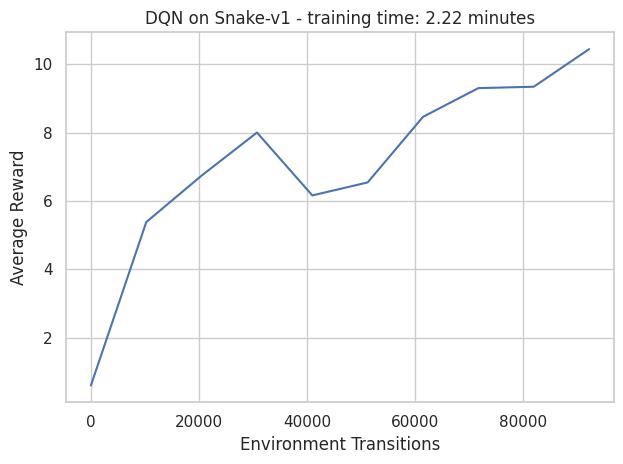

In [9]:
%matplotlib inline
sns.set(style="whitegrid")

num_env_transitions = ROLLOUT_LEN*TRAINING_ITERS*TRAINING_EVAL_ITERS
x_values = np.asarray(jnp.arange(0, num_env_transitions, num_env_transitions/len(avg_reward)))
avg_reward = np.asarray(avg_reward)

sns.lineplot(x=x_values, y=avg_reward)
plt.xlabel('Environment Transitions')
plt.ylabel('Average Reward')
plt.title(f'DQN on Snake-v1 - training time: {np.round((total_time)/60, 2)} minutes')

plt.tight_layout()
plt.show()